# Neural Network

An artificial neural network (or neural network for short) is a predictive model motivated by the way the brain operates. Think of the brain as a collection of neuronswired together. Each **neuron** looks at the outputs of the other neurons that feed into it, does a calculation, and then either fires (if the calculation exceeds some thresh‐
hold) or doesn’t (if it doesn’t).
Accordingly, artificial neural networks consist of artificial neurons, which perform similar calculations over their inputs. Neural networks **can solve a wide variety of problems** like **handwriting recognition** and **face detection**, and they are used heavily in **deep learning**, one of the trendiest subfields of data science. However, most neural networks are **“black boxes”** inspecting their details doesn’t give you much understanding of how they’re solving a problem. And **large neural networks can be difficult to train**. For most problems you’ll encounter as a budding data scientist, they’re probably not the right choice. Someday, when you’re trying to build an artificial intelligence to bring about the Singularity, they very well might be.

## Perceptrons

Pretty much the simplest neural network is the perceptron, which approximates a **single neuron** with n binary inputs. It computes a weighted sum of its inputs and “fires” if that weighted sum is zero or greater:

In [45]:
def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))


def step_function(x):
    return 1 if x >= 0 else 0

def perceptron_output(weights, bias, x):
    """returns 1 if the perceptron 'fires', 0 if not"""
    calculation = dot(weights, x) + bias
    return step_function(calculation)

For example, we can create an AND gate (which returns 1 if both its inputs are 1 but returns 0 if one of its inputs is 0) with:

In [46]:
weights = [2, 2]
bias = -3

print(perceptron_output(weights, bias, [1,1] ))

1


In [47]:
print(perceptron_output(weights, bias, [1,0] ))

0


## Feed-Forward Neural Networks

The topology of the brain is enormously **complicated**, so it’s common to approximate it with an idealized feed-forward neural network that consists of discrete layers of neurons, each connected to the next. This typically entails an **input layer** (which receives inputs and feeds them forward unchanged), one or more **“hidden layers”** (each of which consists of neurons that take the outputs of the previous layer, per‐
forms some calculation, and passes the result to the next layer), and an **output layer** (which produces the final outputs).
Just like the perceptron, each (noninput) neuron has a **weight** corresponding to each of its inputs and a bias. To make our representation simpler, we’ll add the bias to the end of our weights vector and give each neuron a bias input that always equals 1.
As with the perceptron, for each neuron we’ll sum up the products of its inputs and its weights. But here, rather than outputting the step_function applied to that product, we’ll output a smooth approximation of the step function. In particular, we’ll use the **sigmoid function**.

In [48]:
import math 

def sigmoid(t):
    return 1 / (1 + math.exp(-t))

def neuron_output(weights, inputs):
    return sigmoid(dot(weights, inputs))


def feed_forward(neural_network, input_vector):
    """takes in a neural network (represented as a list of lists of lists of weights)
    and returns the output from forward-propagating the input"""

    outputs = []

    for layer in neural_network:

        input_with_bias = input_vector + [1]             # add a bias input
        output = [neuron_output(neuron, input_with_bias) # compute the output
                  for neuron in layer]                   # for this layer
        outputs.append(output)                           # and remember it

        # the input to the next layer is the output of this one
        input_vector = output
        
    return outputs

### X-OR

In [49]:
xor_network = [ # hidden layer
    [[20, 20, -30],
     [20, 20, -10]],
    # output layer
    [[-60, 60, 30]]]

for x in (0,1):
    for y in (0,1):
        print("x ", x, " y ", y, " feed forward ", feed_forward(xor_network, [x,y])[-1])

x  0  y  0  feed forward  [0.9999999999999067]
x  0  y  1  feed forward  [1.0]
x  1  y  0  feed forward  [1.0]
x  1  y  1  feed forward  [0.9999999999999067]


## Backpropagation

Usually we don’t build neural networks by hand. This is in part because we use them to solve much bigger problems an image recognition problem might involve hundreds or thousands of neurons. And it’s in part because we usually won’t be able to **“reason out”** what the neurons should be.
Instead (as usual) **we use data to train neural networks**. One popular approach is an algorithm called backpropagation that has similarities to the gradient descent algorithm we looked at earlier.
Imagine we have a training set that consists of input vectors and corresponding target output vectors. For example, in our previous xor_network example, the input vector [1, 0] corresponded to the target output [1] . And imagine that our network has some set of weights. We then adjust the weights using the following algorithm:

1. Run feed_forward on an input vector to produce the outputs of all the neurons in the network.
2. This results in an error for each output neuron—the difference between its output and its target.
3. Compute the gradient of this error as a function of the neuron’s weights, and adjust its weights in the direction that most decreases the error.
4. “Propagate” these output errors backward to infer errors for the hidden layer.
5. Compute the gradients of these errors and adjust the hidden layer’s weights in the same manner.

In [50]:
def backpropagate(network, input_vector, target):

    hidden_outputs, outputs = feed_forward(network, input_vector)

    # the output * (1 - output) is from the derivative of sigmoid
    output_deltas = [output * (1 - output) * (output - target[i])
                     for i, output in enumerate(outputs)]

    # adjust weights for output layer (network[-1])
    for i, output_neuron in enumerate(network[-1]):
        for j, hidden_output in enumerate(hidden_outputs + [1]):
            output_neuron[j] -= output_deltas[i] * hidden_output

    # back-propagate errors to hidden layer
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                      dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # adjust weights for hidden layer (network[0])
    for i, hidden_neuron in enumerate(network[0]):
        for j, input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input

## Example: Defeating a CAPTCHA

To make sure that people registering for your site are actually people, the VP of Product Management wants to implement a CAPTCHA as part of the registration process.
In particular, he’d like to show users a picture of a digit and require them to input that digit to prove they’re human.
He doesn’t believe you that computers can easily solve this problem, so you decide to convince him by creating a program that can easily solve the problem.

We'll represent each digit as a 5 x 5 image.

For instance zero digit would be represented as:

In [51]:
zero_digit = [1,1,1,1,1, 
              1,0,0,0,1,
              1,0,0,0,1,
              1,0,0,0,1,
              1,1,1,1,1]

We’ll want our output to indicate which digit the neural network thinks it is, so we’ll need 10 outputs. The correct output for digit 4, for instance, will be:

In [52]:
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

Then, assuming our inputs are correctly ordered from 0 to 9, our targets will be:

In [53]:
targets = [[1 if i == j else 0 for i in range(10)] for j in range(10)]
targets

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

In [54]:
import random

random.seed(0)   # to get repeatable results
input_size = 25  # each input is a vector of length 25
num_hidden = 5   # we'll have 5 neurons in the hidden layer
output_size = 10 # we need 10 outputs for each input


raw_digits = [
          """11111
             1...1
             1...1
             1...1
             11111""",

          """..1..
             ..1..
             ..1..
             ..1..
             ..1..""",

          """11111
             ....1
             11111
             1....
             11111""",

          """11111
             ....1
             11111
             ....1
             11111""",

          """1...1
             1...1
             11111
             ....1
             ....1""",

          """11111
             1....
             11111
             ....1
             11111""",

          """11111
             1....
             11111
             1...1
             11111""",

          """11111
             ....1
             ....1
             ....1
             ....1""",

          """11111
             1...1
             11111
             1...1
             11111""",

          """11111
             1...1
             11111
             ....1
             11111"""]

def make_digit(raw_digit):
    return [1 if c == '1' else 0 for row in raw_digit.split("\n") for c in row.strip()]

inputs = list(map(make_digit, raw_digits))

inputs

[[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]

In [55]:
# each hidden neuron has one weight per input, plus a bias weight
hidden_layer = [[random.random() for __ in range(input_size + 1)]
for __ in range(num_hidden)]

# each output neuron has one weight per hidden neuron, plus a bias weight
output_layer = [[random.random() for __ in range(num_hidden + 1)] for __ in range(output_size)]

# the network starts out with random weights
network = [hidden_layer, output_layer]

# 10,000 iterations seems enough to converge
for __ in range(10000):
    for input_vector, target_vector in zip(inputs, targets):
        backpropagate(network, input_vector, target_vector)

In [59]:
def predict(input):
    return feed_forward(network, input)[-1]

ret = predict(inputs[7])

ret = [round(out, 2) for out in ret]

ret 

[0.02, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.97, 0.0, 0.0]

In [62]:
ret = predict([0,1,1,1,0,  # .@@@.
               0,0,0,1,1,  # ...@@
               0,0,1,1,0,  # ..@@.
               0,0,0,1,1,  # ...@@
               0,1,1,1,0]) # .@@@.

In [69]:
r= map(lambda x: round(x,2), ret)
print(list(r))

[0.0, 0.01, 0.0, 0.97, 0.0, 0.0, 0.0, 0.01, 0.0, 0.1]


Looks like 3

In [70]:
ret = predict([0,1,1,1,0,   #.@@@.
         1,0,0,1,1,         #@..@@
         0,1,1,1,0,         #.@@@.
         1,0,0,1,1,         #@..@@
         0,1,1,1,0])        #.@@@.

r= map(lambda x: round(x,2), ret)
print(list(r))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.58, 0.0, 0.0, 0.96, 1.0]


Looks like 8

We can plot the weights of each neuron as a 5 × 5 grid corresponding to the 5 × 5 inputs.

We’ll plot zero weights as white, with far-away-from-zero weights darker and darker. And we’ll use crosshatching to indicate negative weights.

In [77]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def patch(x, y, hatch, color):
    """return a matplotlib 'patch' object with the specified
    location, crosshatch pattern, and color"""
    return matplotlib.patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                        hatch=hatch, fill=False, color=color)


def show_weights(neuron_idx):
    weights = network[0][neuron_idx]
    abs_weights = [abs(weight) for weight in weights]

    grid = [abs_weights[row:(row+5)] # turn the weights into a 5x5 grid
            for row in range(0,25,5)] # [weights[0:5], ..., weights[20:25]]

    ax = plt.gca() # to use hatching, we'll need the axis

    ax.imshow(grid, # here same as plt.imshow
              cmap=matplotlib.cm.binary, # use white-black color scale
              interpolation='none') # plot blocks as blocks

    # cross-hatch the negative weights
    for i in range(5): # row
        for j in range(5): # column
            if weights[5*i + j] < 0: # row i, column j = weights[5*i + j]
                # add black and white hatches, so visible whether dark or light
                ax.add_patch(patch(j, i, '/', "white"))
                ax.add_patch(patch(j, i, '\\', "black"))
    plt.show()

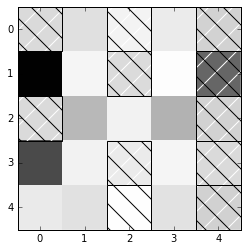

In [81]:
show_weights(0)

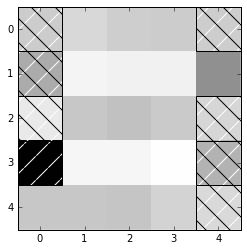

In [79]:
show_weights(2)

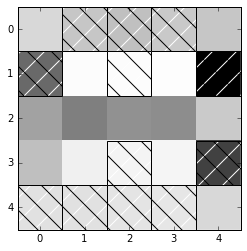

In [82]:
show_weights(4)

the first hidden neuron has large positive weights in the left column and in the center of the middle row, while it has large negative weights in the right column.